# <font color = "#d53e4f"><b>House Price Prediction</b>

# <h3>Importing libraries</h3>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import sklearn.metrics as sklm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder



# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
import os
import warnings
from pathlib import Path


<h3>Loading the dataset</h3>

In [3]:
# Read data
data_dir = Path("House Prices Advanced Regression Techniques")
df_train = pd.read_csv(data_dir / "train.csv", index_col="Id")
df_test = pd.read_csv(data_dir / "test.csv", index_col="Id")
# Merge the splits so we can process them together
df = pd.concat([df_train, df_test])
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


<h3>Basic insights of dataset</h3>

In [4]:
df.shape

(2919, 80)

In [5]:
df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

## View data types, missing values and duplicates

In [6]:
def summary(df):
    summary_df = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary_df['Missing:Zeros'] = ((df == 0).sum())
    summary_df['Missing:np.nan'] = (df.isnull()).sum()
    summary_df['Missing:None'] = (df == "None").sum()
    summary_df['total'] = summary_df['Missing:Zeros'] + summary_df['Missing:np.nan'] + summary_df['Missing:None']
    summary_df['Percent'] = 100*summary_df['total']/len(df)
    summary_df['Duplicates'] = df.duplicated().sum()
    summary_df['Unique'] = df.nunique().values
    summary_df['Count'] = df.count().values
    return summary_df.sort_values(ascending = False, by = 'Percent')

summary(df).style.background_gradient(cmap='Blues')

,dtypes,Missing:Zeros,Missing:np.nan,Missing:None,total,Percent,Duplicates,Unique,Count
PoolQC,object,0,2909,0,2909,99.657417,0,3,10
PoolArea,int64,2906,0,0,2906,99.554642,0,14,2919
3SsnPorch,int64,2882,0,0,2882,98.732443,0,31,2919
LowQualFinSF,int64,2879,0,0,2879,98.629668,0,36,2919
MiscVal,int64,2816,0,0,2816,96.471394,0,38,2919
MiscFeature,object,0,2814,0,2814,96.402878,0,4,105
BsmtHalfBath,float64,2742,2,0,2744,94.004796,0,3,2917
Alley,object,0,2721,0,2721,93.216855,0,2,198
ScreenPorch,int64,2663,0,0,2663,91.229873,0,121,2919
BsmtFinSF2,float64,2571,1,0,2572,88.112367,0,272,2918


# Data Preprocessing

## Dealing with missing values

* Drop columns that have high percentage of missing values
* Some columns have zeros as code for categorical features, we should make sure not to drop them
* The rest of the missing values will be droped

In [7]:

df.drop(["PoolQC","PoolArea","3SsnPorch","LowQualFinSF","MiscVal","BsmtHalfBath",'Alley',"ScreenPorch","BsmtFinSF2","EnclosedPorch","Fence","HalfBath","MasVnrType","MasVnrArea","MiscFeature","FireplaceQu"], axis = 1, inplace = True)

In [8]:
df.dropna(subset = ["SalePrice"],axis = 0, inplace = True)

In [9]:
df.shape

(1460, 64)

# Log Transformation for the target

In [10]:
df["SalePrice"] = np.log1p(df["SalePrice"])

In [11]:
X = df.copy()
y = X.pop("SalePrice")

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()


In [12]:
from sklearn.model_selection import train_test_split


# Divide data into training and validation subsets
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

In [13]:
X_train.shape

(1168, 63)

## Imputation

In [14]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer()
# impute training
X_train_imputed =imputer.fit_transform(X_train)

#impute testing
X_valid_imputed =imputer.transform(X_valid)
X_train = pd.DataFrame(data = X_train_imputed,  columns = X_train.columns)
X_valid = pd.DataFrame(data = X_valid_imputed,  columns = X_valid.columns)

# Features Engneering

## Features Utility Scores

In [15]:
discrete_features = X_train.dtypes == int

In [16]:
from sklearn.feature_selection import mutual_info_regression
def make_mi_scores(X_train,y_train,discrete_features):
    mi_scores = mutual_info_regression(X_train,y_train,discrete_features =discrete_features )
    mi_scores = pd.Series(mi_scores, name = "MI Scores", index = X_train.columns)
    mi_scores = mi_scores.sort_values(ascending = False)
    return mi_scores
mi_scores =  make_mi_scores(X_train,y_train,discrete_features)
mi_scores

OverallQual     0.568531
Neighborhood    0.489858
GrLivArea       0.470620
GarageCars      0.389639
TotalBsmtSF     0.386780
                  ...   
Utilities       0.000735
Condition2      0.000552
Street          0.000000
MoSold          0.000000
YrSold          0.000000
Name: MI Scores, Length: 63, dtype: float64

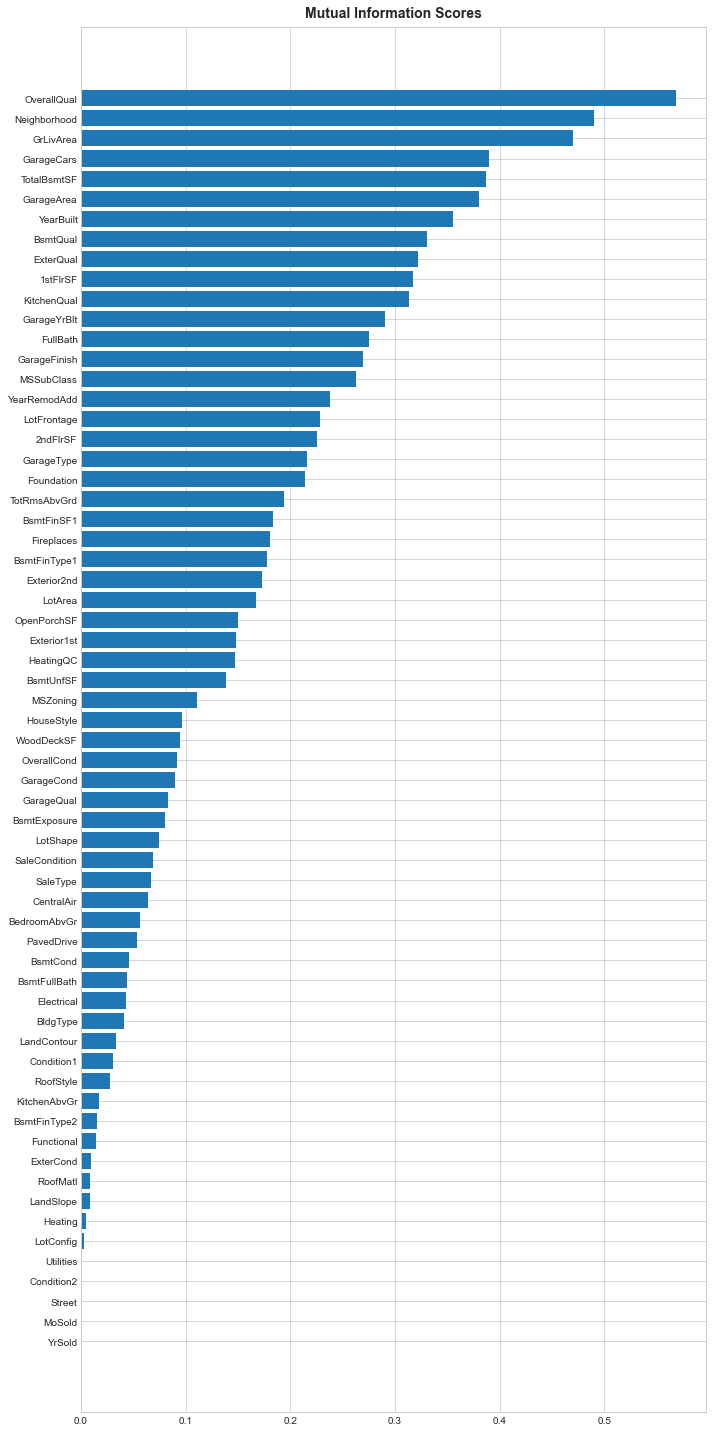

In [17]:
def plot_mi_scores(scores):
    fig, ax = plt.subplots(figsize=(10,20))
    scores = scores.sort_values(ascending = True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    
    
plot_mi_scores(mi_scores)

## Features Selection

In [18]:
# Drop features with 0.0 MI score
def drop_uninformative(df, mi_scores):
    return df.loc[:, mi_scores > 0.0]
X_train = drop_uninformative(X_train, mi_scores)

In [19]:
X_valid = drop_uninformative(X_valid, mi_scores)

## Helping functions

### Plotting scatter plot and histogram for model evaluation

In [20]:
def residuals_plot(y_pred):
    '''
    1) Ploting scatter plot
    2) Plotting histogram'''
    
    resids = np.subtract(y_valid,y_pred)
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    # Left: Sxatter plot
    ax[0] = sns.regplot(y_pred,resids, fit_reg = False, ax=ax[0])
    ax[0].set_xlabel('Residual values')
    ax[0].set_ylabel('Count')
    ax[0].set_title('Scatter of residuals')

    # Right: Histogram
    ax[1] = sns.distplot(resids, ax=ax[1])
    ax[1].set_xlabel('Residual values')
    ax[1].set_ylabel('Count')
    ax[1].set_title('Histogram of residuals')
    plt.show()

## Modeling

### Random Forest Regressor

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score


In [22]:
#Create a Randomodelm Forest Classifier object
baseline = RandomForestRegressor(n_estimators = 200, random_state=0)

In [23]:
# Train the classifier


rfc = baseline.fit(X_train, y_train)
# Make predictions
yhat_train1 = rfc.predict(X_train)
yhat_test1 = rfc.predict(X_valid)

### Evaluate the performance

In [24]:
from sklearn import metrics 

In [25]:
#Evaluate the model using r2 and mean squared
train_mse = mean_squared_error(y_train, yhat_train1)
test_mse = mean_squared_error(y_valid, yhat_test1)
train_r2 = r2_score(y_train, yhat_train1)
test_r2 = r2_score(y_valid, yhat_test1)
#Print the evaluation metrics
print("Train MSE:           ",train_mse)
print("Test MSE:            ",test_mse)
print("Train R_Squareg:     ",train_r2)
print("Test R_Squared:      ",test_r2 )
        

Train MSE:            0.0028828431859118544
Test MSE:             0.01803657232473784
Train R_Squareg:      0.9821452778945213
Test R_Squared:       0.8808665613117193


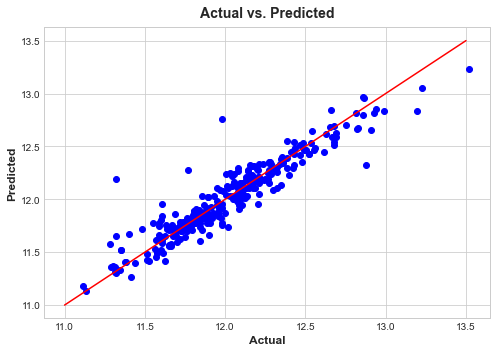

In [26]:
# Plot actual vs. predicted values for Decision Tree
plt.figure(figsize=( 7,5))
plt.scatter(y_valid, yhat_test1, color='b')
plt.plot(np.array([11,13.5]), np.array([11,13.5]), color='red')
plt.title('Actual vs. Predicted') 
plt.xlabel('Actual')
plt.ylabel('Predicted')

plt.show()

### Linear Regression

In [27]:
lre=LinearRegression()
### training -fitting- the model
lre.fit(X_train, y_train)
yhat_train2 = lre.predict(X_train)
yhat_test2 = lre.predict(X_valid)

In [28]:
#Evaluate the model using r2 and mean squared
train_mse = mean_squared_error(y_train, yhat_train2)
test_mse = mean_squared_error(y_valid, yhat_test2)
train_r2 = r2_score(y_train, yhat_train2)
test_r2 = r2_score(y_valid, yhat_test2)
#Print the evaluation metrics
print("Train MSE:           ",train_mse)
print("Test MSE:            ",test_mse)
print("Train R_Squareg:     ",train_r2)
print("Test R_Squared:      ",test_r2 )

Train MSE:            0.0161223145234401
Test MSE:             0.041970515383342025
Train R_Squareg:      0.9001473798783493
Test R_Squared:       0.7227803747234665


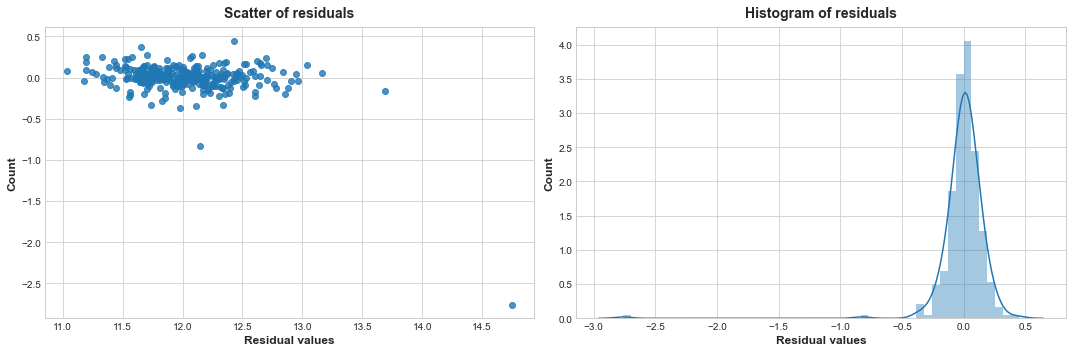

In [29]:
residuals_plot(yhat_test2)

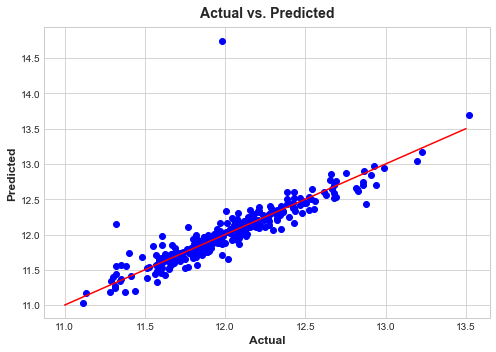

In [30]:
# Plot actual vs. predicted values for Decision Tree
plt.figure(figsize=( 7,5))
plt.scatter(y_valid, yhat_test2, color='b')
plt.plot(np.array([11,13.5]), np.array([11,13.5]), color='red')
plt.title('Actual vs. Predicted') 
plt.xlabel('Actual')
plt.ylabel('Predicted')

plt.show()

In [31]:
from sklearn.neighbors import KNeighborsRegressor


In [32]:
knn = KNeighborsRegressor().fit(X_train, y_train)

y_train_pred = knn.predict(X_train)
y_val_pred = knn.predict(X_valid)


#Evaluate the model using r2 and mean squared
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_valid, y_val_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_valid, y_val_pred)
#Print the evaluation metrics
print("Train MSE:           ",train_mse)
print("Test MSE:            ",test_mse)
print("Train R_Squareg:     ",train_r2)
print("Test R_Squared:      ",test_r2 )

Train MSE:            0.03235690979157798
Test MSE:             0.04872082348886276
Train R_Squareg:      0.7995993554751988
Test R_Squared:       0.6781938866515015


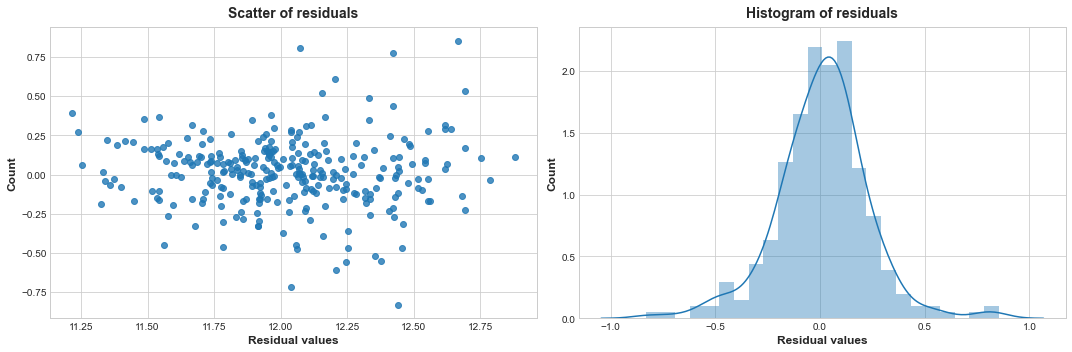

In [33]:
residuals_plot(y_val_pred)

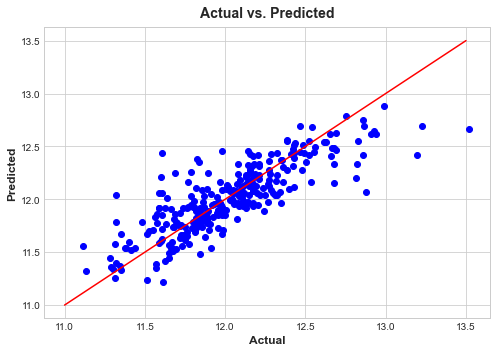

In [34]:
# Plot actual vs. predicted values for Decision Tree
plt.figure(figsize=( 7,5))
plt.scatter(y_valid,  y_val_pred, color='b')
plt.plot(np.array([11,13.5]), np.array([11,13.5]), color='red')
plt.title('Actual vs. Predicted') 
plt.xlabel('Actual')
plt.ylabel('Predicted')

plt.show()

## Discusion

### Comparing models performance

In [35]:
def measure_error(y_train, y_train_pred,y_valid, y_val_pred, label):
    return pd.Series({"Train MSE": mean_squared_error(y_train, y_train_pred),
                     "Test MSE": mean_squared_error(y_valid, y_val_pred),
                     "Train R_Squareg": r2_score(y_train, y_train_pred),
                     "Test R_Squared": r2_score(y_valid, y_val_pred)}, 
                     name = label)

In [36]:
RFC = pd.concat([measure_error(y_train, yhat_train1,y_valid, yhat_test1,"RFC")],axis = 1)
Lin_reg = pd.concat([measure_error(y_train, yhat_train2,y_valid, yhat_test2,"Lin_reg")],axis = 1)
KNN = pd.concat([measure_error(y_train, y_train_pred,y_valid, y_val_pred,"KNN")],axis = 1)
compare_models =  pd.concat([RFC,Lin_reg,KNN],axis =1)
compare_models.style.background_gradient(cmap='Blues')


,RFC,Lin_reg,KNN
Train MSE,0.002883,0.016122,0.032357
Test MSE,0.018037,0.041971,0.048721
Train R_Squareg,0.982145,0.900147,0.799599
Test R_Squared,0.880867,0.722780,0.678194


## Result:
### **The best model based on test R2 IS : Random forest Classifier**